In [14]:
import jax
import numpyro
import blackjax
import numpy as np
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer.util import initialize_model
from numpyro.infer.reparam import TransformReparam
import matplotlib.pyplot as plt

In [15]:
def eight_schools(J, sigma, y=None):
    mu = numpyro.sample('mu', dist.Normal(2, 5))
    tau = numpyro.sample('tau', dist.HalfCauchy(5))
    with numpyro.plate('J', J):
        theta = numpyro.sample('theta', dist.Normal(mu, tau))
        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [16]:
# Model initialization values
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [17]:
rng_key = jax.random.PRNGKey(0)
init_params, potential_fn_gen, *_ = initialize_model(
    rng_key,
    eight_schools,
    model_args=(J, sigma, y),
    dynamic_args=True,
)

In [18]:
logdensity_fn = lambda position: -potential_fn_gen(J, sigma, y)(position)
initial_position = init_params.z

In [19]:
num_warmup = 150

adapt = blackjax.window_adaptation(
    blackjax.nuts, logdensity_fn, target_acceptance_rate=0.8
)
(last_state, parameters), intermediate_states = adapt.run(rng_key, initial_position, num_warmup)

i:99
covariance:[ 6.3661003   0.37203836 12.610354    9.061763   11.636722   32.69961
 12.23829    17.40624    46.276688   16.758017  ]
best_c_jax:[1.0516925e-01 1.8553957e-01 2.9959153e-02 1.6014416e-04 4.7676355e-02
 1.3437119e-03 3.0061093e-04 1.3069877e-03]


In [20]:
kernel = blackjax.nuts(logdensity_fn, **parameters).step

In [21]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, info = kernel(rng_key, state)
        return state, (state, info)

    keys = jax.random.split(rng_key, num_samples)
    extra, (states, infos) = jax.lax.scan(one_step, initial_state, keys)

    return states, (
        infos.acceptance_rate,
        infos.is_divergent,
        infos.num_integration_steps,
    )

In [22]:
num_sample = 1000

states, infos = inference_loop(rng_key, kernel, last_state, num_sample)
_ = states.position["mu"].block_until_ready()

In [23]:
states[0]

{'mu': Array([ 5.8996773 ,  3.3867867 ,  4.025577  ,  3.7056    ,  2.6610026 ,
         2.5528738 , 11.954833  , 10.508918  , 11.768226  , 11.911977  ,
         9.344393  ,  9.755184  , 10.032558  ,  9.208895  , 11.9767275 ,
        11.560174  , 10.132652  ,  9.082038  ,  6.956901  ,  3.1384254 ,
         7.2405024 ,  6.2707624 ,  7.25859   ,  8.234223  ,  6.820675  ,
         7.5091605 ,  7.798505  ,  7.017651  , 10.244768  ,  6.900202  ,
         8.016085  ,  7.917396  ,  7.049671  ,  5.2186513 ,  2.7756207 ,
         6.0497565 ,  7.1602783 ,  5.4776797 ,  1.7497545 ,  7.1827006 ,
        19.099754  ,  1.4389675 ,  2.216455  ,  3.8103185 ,  3.4214406 ,
         4.1978908 ,  4.9130793 ,  4.4391546 ,  5.4175906 , -2.5205944 ,
         1.0670215 , -0.51400626, -0.54064095,  2.3922708 ,  2.6185172 ,
         8.777689  ,  6.939829  ,  2.9621396 ,  5.5188212 ,  6.16716   ,
         3.704372  ,  8.445445  ,  7.5210767 ,  8.118155  ,  4.0749974 ,
         5.496458  ,  5.2036386 ,  5.2036386 

In [24]:
def scatterplt(samples):
    fig, axes = plt.subplots(4, 2, figsize=(10, 12))
    axes = axes.flatten()
    # reparam_sample, mvn, mu_theta, std_theta = reparameterize_samples_dist(samples, best_c)
    # reparam_sample = reparam_sample if reparam else samples['theta'].T
    samples_theta = samples['theta'].T
    for i in range(8):
        axes[i].scatter(samples_theta[i], samples['tau'])
        axes[i].set_xlabel(f'theta_{i}')
        axes[i].set_ylabel('log_std')

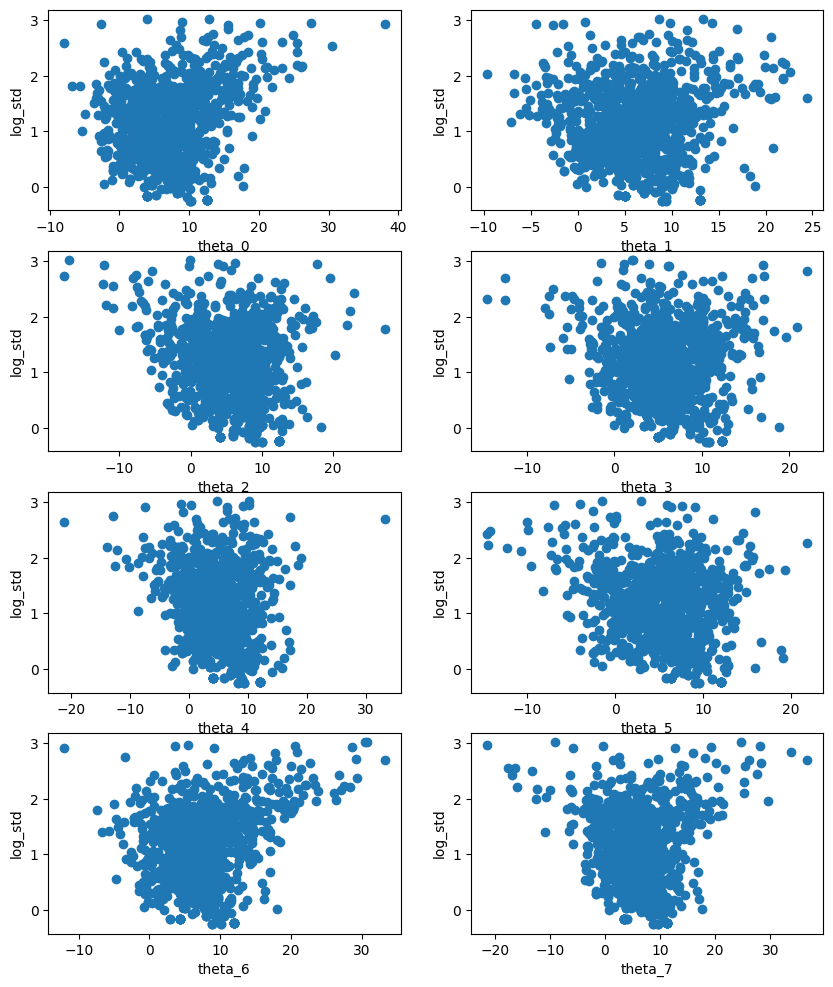

In [25]:
scatterplt(states[0])

In [26]:
acceptance_rate = np.mean(infos[0])
num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acceptance_rate:.2f}")
print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.83
There were 1.30% divergent transitions
